# Modelo B 


por: Catalina Alvarez 

In [5]:
!pip install inflect
!pip install --upgrade wordcloud



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# 1. Preparación del Ambiente

In [6]:
import pandas as pd
#from ydata_profiling import ProfileReport

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
#from num2words import num2words
import matplotlib.pyplot as plt
import re, string, unicodedata
import matplotlib

%matplotlib inline
import numpy as np
import inflect
import joblib
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MarianaLozano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\MarianaLozano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Carga de datos

In [7]:
df_original = pd.read_csv(r'C:\Users\MarianaLozano\OneDrive - NOLDATA.CO\Documents\Universidad\Octavo semestre\BI\Proyecto1-BI\Etapa 1\datos\fake_news_spanish.csv', sep=';', encoding='utf-8')
df_original.head()


,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


In [8]:
train = df_original.copy()
train.head()

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


# 2. Calidad de los datos

Se van a analizar 4 dimensiones distintas con respecto a la calidad de los datos (Completitud, Validez, Unicidad y Consistencia)

# Completitud

Bajo una inspeccion sencilla, parece no haber problemas de completitud en los datos

In [9]:
train.isnull().sum()

ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

In [10]:
train.count()

ID             57063
Label          57063
Titulo         57047
Descripcion    57063
Fecha          57063
dtype: int64

In [11]:
train['Label'].value_counts()

Label
1    33158
0    23905
Name: count, dtype: int64

In [12]:
# strip all values in the column
train['Descripcion'] = train['Descripcion'].str.strip()
# count all values in the column where the value is an empty string
train['Descripcion'].isnull().sum()

np.int64(0)

# Validez 
Se identifican los siguientes problemas de validez: 
Los textos en el dataset tienen problemas, vocales con tilde han sido remplazados por caracteres no validos. 


In [13]:
def fix_encoding(text):
    replacements = {
        'Ã¡': 'á',
        'Ã©': 'é',
        'Ã­': 'í',
        'Ã³': 'ó',
        'Ãº': 'ú',
        'Ã±': 'ñ'
    }
    
    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)
    
    return text

train['Descripcion'] = train['Descripcion'].apply(fix_encoding)

Convertir la columna Titulo de float a string para aplicar los cambios de fix_encoding

In [61]:
# Convertir la columna "Titulo" de float a string
train["Titulo"] = train["Titulo"].astype(str)

# Verificar el cambio de tipo de dato
train.dtypes["Titulo"]

dtype('O')

In [15]:
train['Titulo'] = train['Titulo'].apply(fix_encoding)

In [16]:
train.head(5)

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


# Unicidad 
En primera instancia, el dataset no tiene columnas unicas sigueindo alguna restriccion de negocio. Luego de una sencilla inspeccion, parece haber filas totalmente duplicadas. 

In [17]:
train.duplicated().sum()

np.int64(445)

# Consistencia 
La coluumna "ID" no es unica en su totalidad, es posible que haya inconsistencias 

In [18]:
train["ID"].nunique() == len(train)

False

# Perfilamiento de datos 

Eliminacion de datos duplicados

In [19]:
train.drop_duplicates(inplace=True)

In [20]:
train.count()

ID             56618
Label          56618
Titulo         56618
Descripcion    56618
Fecha          56618
dtype: int64

In [21]:
def mostrar_grafico1(palabras,stopwords=[]):
    comment_words = ''
    
    # iterate through the csv file
    for val in palabras:
        
        # typecaste each val to string
        val = str(val)
    
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
    
    
    wordcloud = WordCloud(width = 600, height = 600,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
    
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

A continuacion, se ilustrara que palabras suelen repetirse y encontrarse en los Label's 0 y 1 

---------- Words for class: 1 ----------


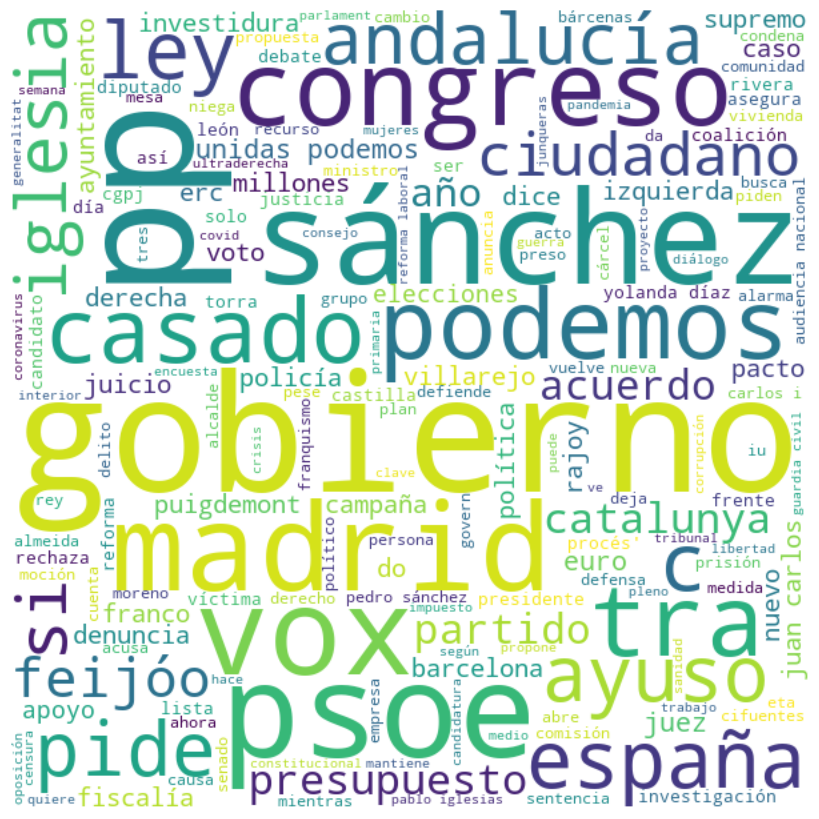

---------- Words for class: 0 ----------


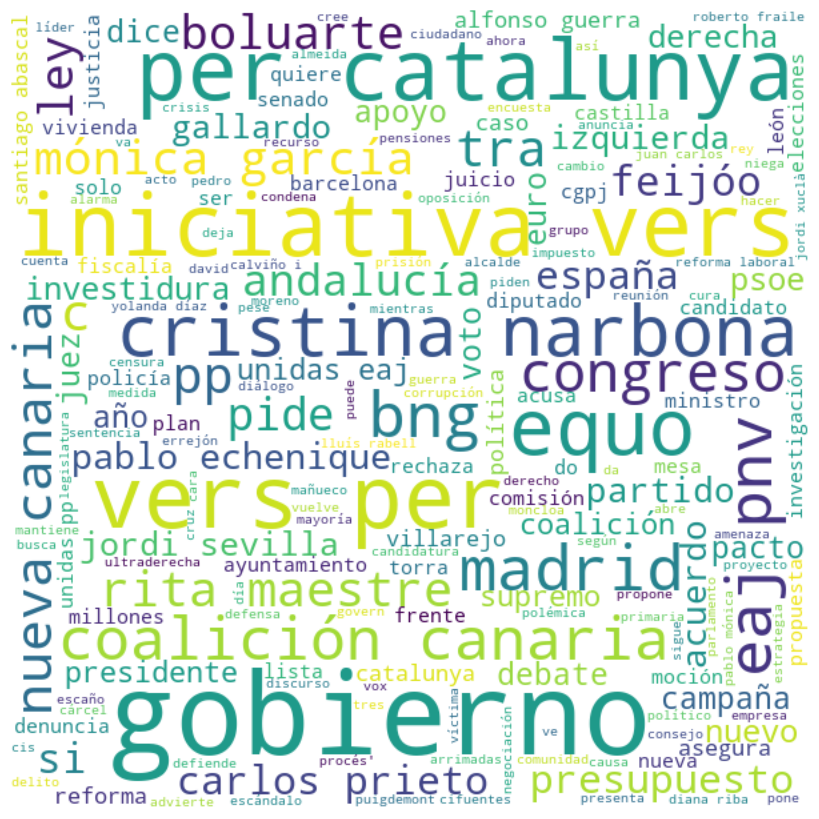

In [22]:
stop_words = set(nltk.corpus.stopwords.words('spanish'))

for i in train['Label'].unique():
    print(f'---------- Words for class: {i} ----------')
    mostrar_grafico1(train.loc[train['Label']==i,'Titulo'], stopwords=stop_words)

In [23]:
train

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018
...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,08/09/2020
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,12/07/2018
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022


# Preparacion de datos

In [24]:
X_train, y_train = train['Titulo'], train['Label'] 
display(X_train)
y_train

0        'The Guardian' va con Sánchez: 'Europa necesit...
1        REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...
2        El 'Ahora o nunca' de Joan Fuster sobre el est...
3        Iglesias alienta a Yolanda Díaz, ERC y EH Bild...
4        Puigdemont: 'No sería ninguna tragedia una rep...
                               ...                        
57058    El Defensor del Pueblo reclama a la Comunidad ...
57059    El EQUO plantea ceder la presidencia de la Com...
57060    Alberto Garzón: 'Que los Borbones son unos lad...
57061    Vox exige entrar en el Gobierno de Castilla y ...
57062    Unas 300 personas protestan contra la visita d...
Name: Titulo, Length: 56618, dtype: object

0        1
1        0
2        1
3        1
4        0
        ..
57058    1
57059    0
57060    1
57061    1
57062    1
Name: Label, Length: 56618, dtype: int64

# Modificacion de Caracteres

Se pasan todos los caracteres a minusculas, se eliminan textos de puntuacion y stop words (suelen ser articulos y conectores)

1. Cambiar minusculas 

In [25]:
def to_lower(words: list[str]):
    return [word.lower() for word in words]

2. Quitar puntuacion

In [26]:
def remove_punctuation(words: list[str]):
    return [word for word in words if word.isalnum()]

3. Eliminar StopWords

In [27]:
def remove_stopwords(words: list[str]):
    stopwords = set(nltk.corpus.stopwords.words('spanish'))
    return [word for word in words if word not in stopwords]

In [28]:
def preprocessing(words):
    words = to_lower(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

Ahora se gace un procedimiento de Tokenizacion para desglozar palabras 

In [29]:
new_X_train = X_train.apply(word_tokenize)
new_X_train = new_X_train.apply(preprocessing) 
new_X_train.head()

0    [guardian, va, sánchez, necesita, apuesta, dé,...
1    [revelan, gobierno, negocio, liberación, mirel...
2    [nunca, joan, fuster, estatuto, valenciano, cu...
3    [iglesias, alienta, yolanda, díaz, erc, eh, bi...
4    [puigdemont, ninguna, tragedia, repetición, el...
Name: Titulo, dtype: object

In [30]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('spanish')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

In [31]:

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [32]:
def stem_and_lemmatize(words):
    #words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

In [33]:
new_X_train = new_X_train.apply(stem_and_lemmatize) 
new_X_train.head()

0    [guardian, va, sánchez, necesita, apuesta, dé,...
1    [revelan, gobierno, negocio, liberación, mirel...
2    [nunca, joan, fuster, estatuto, valenciano, cu...
3    [iglesias, alienta, yolanda, díaz, erc, eh, bi...
4    [puigdemont, ninguna, tragedia, repetición, el...
Name: Titulo, dtype: object

# Separación Train/Test

In [34]:
from sklearn.model_selection import train_test_split
import numpy as np

# Definir variables de entrada (X) y salida (y)
X = df_original['Titulo']  # Se usará el título de las noticias como input
y = df_original['Label']  # La etiqueta de la noticia es la variable de salida

# División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape



((42797,), (14266,), (42797,), (14266,))

# Cuenta de labels por cada conjunto de datos

In [41]:
from collections import Counter

train_dict = dict(Counter(y_train))
test_dict = dict(Counter(y_test))

# Mostrar conteo de etiquetas para train y test
pd.DataFrame({'Train': train_dict, 'Test': test_dict})


,Train,Test
1,24863,8295
0,17934,5971


# Vectorización de texto

In [43]:
train.dropna(inplace=True)

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

# Fill missing values with empty string
X_train = X_train.fillna('')
X_test = X_test.fillna('')

cv = CountVectorizer(min_df=0., max_df=1.)
X_train_features = cv.fit_transform(X_train)
X_test_features = cv.transform(X_test)
X_train_features.shape, X_test_features.shape


((42797, 23839), (14266, 23839))

# Entrenamiento del modelo Naive Bayes

In [46]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=1.)
mnb.fit(X_train_features, y_train)



MultinomialNB()

# Evaluación del modelo

In [47]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

y_pred = mnb.predict(X_test_features)
y_pred_train = mnb.predict(X_train_features)

print('Accuracy (Train):', metrics.accuracy_score(y_train, y_pred_train))
print('Accuracy (Test):', metrics.accuracy_score(y_test, y_pred))

mnb_cv_scores = cross_val_score(mnb, X_train_features, y_train, cv=5)
mnb_cv_mean_score = np.mean(mnb_cv_scores)
print('CV Accuracy (5-fold):', mnb_cv_scores)
print('Mean CV Accuracy:', mnb_cv_mean_score)

print("\n---- Classification Report (Train) ----\n")
print(metrics.classification_report(y_train, y_pred_train))

print("\n---- Classification Report (Test) ----\n")
print(metrics.classification_report(y_test, y_pred))


Accuracy (Train): 0.8550365679837372
Accuracy (Test): 0.7937053133323987
CV Accuracy (5-fold): [0.79240654 0.79883178 0.80032714 0.79226545 0.79366748]
Mean CV Accuracy: 0.7954996789737643

---- Classification Report (Train) ----

              precision    recall  f1-score   support

           0       0.90      0.73      0.81     17934
           1       0.83      0.94      0.88     24863

    accuracy                           0.86     42797
   macro avg       0.87      0.84      0.85     42797
weighted avg       0.86      0.86      0.85     42797


---- Classification Report (Test) ----

              precision    recall  f1-score   support

           0       0.81      0.66      0.73      5971
           1       0.79      0.89      0.83      8295

    accuracy                           0.79     14266
   macro avg       0.80      0.78      0.78     14266
weighted avg       0.80      0.79      0.79     14266



# Visualización de la Matriz de Confusión

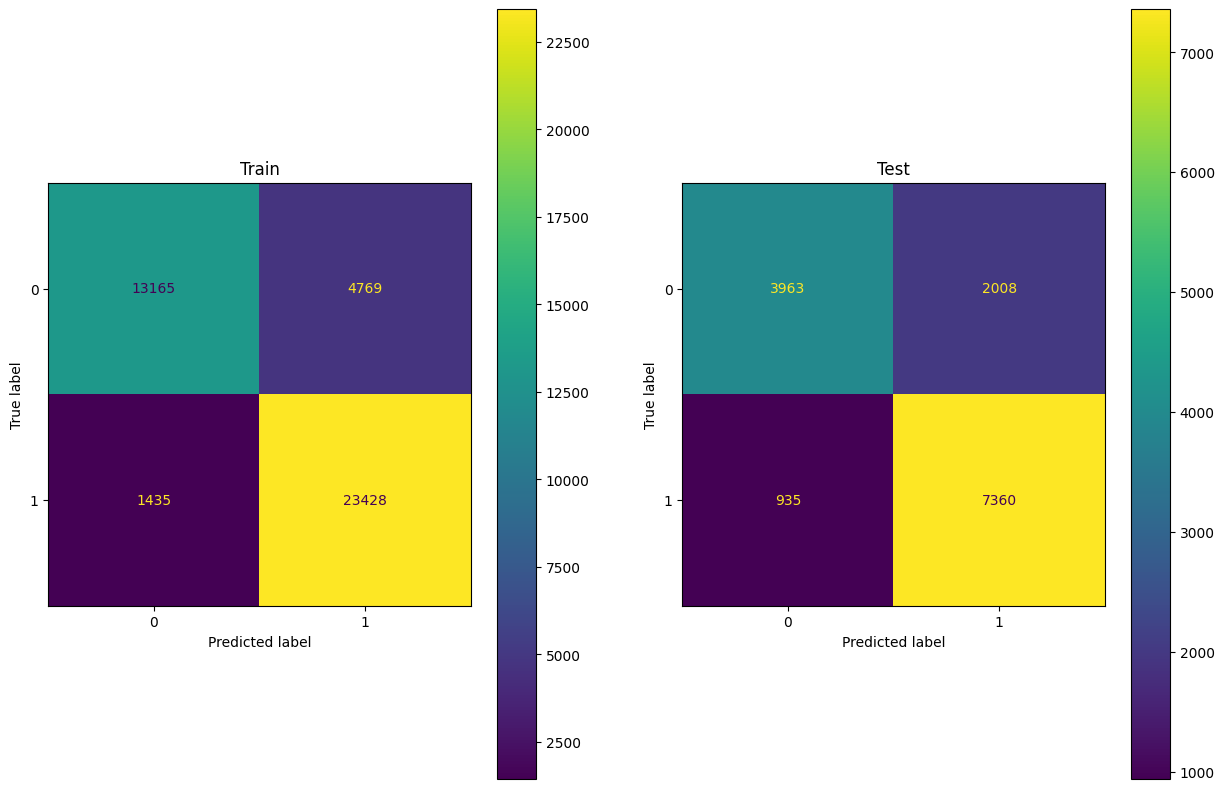

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

train_cm = confusion_matrix(y_train, y_pred_train, labels=mnb.classes_)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=mnb.classes_)
axes[0].set_title('Train')
disp_train.plot(ax=axes[0])

test_cm = confusion_matrix(y_test, y_pred, labels=mnb.classes_)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=mnb.classes_)
axes[1].set_title('Test')
disp_test.plot(ax=axes[1])

plt.show()


# Optimización del modelo con GridSearchCV

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

mnb_pipeline = Pipeline([
    ('cv', CountVectorizer()),
    ('mnb', MultinomialNB())
])

param_grid = {
    'cv__min_df': [0.0, 0.1, 0.2],
    'cv__max_df': [1.0, 0.9, 0.8],
    'mnb__alpha': [1e-5, 1e-4, 1e-2, 1e-1, 1]
}

gs_mnb = GridSearchCV(mnb_pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
gs_mnb.fit(X_train, y_train)

# Mostrar mejores parámetros
cv_results = gs_mnb.cv_results_
results_df = pd.DataFrame({'rank': cv_results['rank_test_score'],
                           'params': cv_results['params'],
                           'cv score (mean)': cv_results['mean_test_score'],
                           'cv score (std)': cv_results['std_test_score']})
results_df = results_df.sort_values(by='rank').head()
pd.set_option('display.max_colwidth', 100)
results_df

best_mnb_test_score = gs_mnb.score(X_test, y_test)
print('Test Accuracy :', best_mnb_test_score)


Fitting 5 folds for each of 45 candidates, totalling 225 fits
Test Accuracy : 0.7937053133323987


# Creación del Pipeline Final

In [65]:
from sklearn.preprocessing import FunctionTransformer
import re
from nltk.tokenize import word_tokenize

def normalize_documents(doc):
    doc = re.sub(r'[^a-zA-Z\s]', '', doc)  # Eliminar caracteres especiales
    doc = doc.lower().strip()

    tokens = word_tokenize(doc)
    doc = ' '.join(tokens)

    return doc

normalize_corpus = np.vectorize(normalize_documents)

preprocessing_pipeline = Pipeline([
    ('normalize_corpus', FunctionTransformer(normalize_corpus)),
    ('cv', CountVectorizer(min_df=0., max_df=1.)),
])

pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('clf', MultinomialNB(alpha=1.))
])



# Evaluación del Pipeline

In [71]:
X_train, X_test, y_train, y_test = train_test_split(df_original['Titulo'], df_original['Label'], test_size=0.25, random_state=1)

vectorized_result = pipeline.named_steps['preprocessing'].fit_transform(X_train)
pipeline.named_steps['clf'].fit(vectorized_result, y_train)

pipeline_model = pipeline

y_pred = pipeline_model.predict(X_test)

mnb_cv_scores = cross_val_score(pipeline_model, X_train, y_train, cv=5)
mnb_cv_mean_score = np.mean(mnb_cv_scores)
print(f"Cross Validation Score (5-fold): {mnb_cv_scores}")
print(f"Mean Cross Validation Score: {mnb_cv_mean_score}")

print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred)}")
print(metrics.classification_report(y_test, y_pred))

TypeError: expected string or bytes-like object, got 'float'

# Serialización del Modelo

In [60]:
import joblib
import cloudpickle

serialized = cloudpickle.dumps(pipeline_model)
open('pipeline_model.pkl', 'wb').write(serialized)


NameError: name 'pipeline_model' is not defined

In [ ]:
import os

font_dir = "C:/Windows/Fonts"
fonts = [f for f in os.listdir(font_dir) if f.endswith(".ttf")]
print(fonts)


['arial.ttf', 'arialbd.ttf', 'arialbi.ttf', 'ariali.ttf', 'ariblk.ttf', 'bahnschrift.ttf', 'calibri.ttf', 'calibrib.ttf', 'calibrii.ttf', 'calibril.ttf', 'calibrili.ttf', 'calibriz.ttf', 'cambriab.ttf', 'cambriai.ttf', 'cambriaz.ttf', 'Candara.ttf', 'Candarab.ttf', 'Candarai.ttf', 'Candaral.ttf', 'Candarali.ttf', 'Candaraz.ttf', 'CascadiaCode.ttf', 'CascadiaMono.ttf', 'comic.ttf', 'comicbd.ttf', 'comici.ttf', 'comicz.ttf', 'consola.ttf', 'consolab.ttf', 'consolai.ttf', 'consolaz.ttf', 'constan.ttf', 'constanb.ttf', 'constani.ttf', 'constanz.ttf', 'corbel.ttf', 'corbelb.ttf', 'corbeli.ttf', 'corbell.ttf', 'corbelli.ttf', 'corbelz.ttf', 'cour.ttf', 'courbd.ttf', 'courbi.ttf', 'couri.ttf', 'ebrima.ttf', 'ebrimabd.ttf', 'framd.ttf', 'framdit.ttf', 'Gabriola.ttf', 'gadugi.ttf', 'gadugib.ttf', 'georgia.ttf', 'georgiab.ttf', 'georgiai.ttf', 'georgiaz.ttf', 'himalaya.ttf', 'HPSimplified.ttf', 'hpsimplifiedhans-light.ttf', 'hpsimplifiedhans-regular.ttf', 'hpsimplifiedjpan-light.ttf', 'hpsimplif